# DigitRecognizer

[Kaggle competition: Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer)


数字识别，一个基于MNIST数据集的CV领域入门项目

## references

[Easy-Peasy Detailed CNN Tutorial for Beginners](https://www.kaggle.com/code/akshitsharma1/easy-peasy-detailed-cnn-tutorial-for-beginners/notebook)

<br><br>
# Libraries and Modules

In [1]:
%matplotlib inline

# 引入库和模块
import numpy as np # for numerical computing
import pandas as pd # for manipulation and analysis
import os # for interacting with the operating system 
import matplotlib.pyplot as plt # for creating visualizations
from PIL import Image # for working with images

import torch # for machine learning
import torch.nn as nn # for building neural networks in PyTorch
import torch.optim as optim # for optimizing neural networks in PyTorch
import torchvision # for computer vision tasks in PyTorch
from torchvision import models, transforms # for loading and preprocessing image data
import torchvision.models as models # for using pre-trained models in PyTorch
from torch.utils.data import DataLoader, Dataset # for working with datasets in PyTorch

<br><br>
# Setting Things Up

安装 torchview 库，用于在后续可视化CNN的结构

In [2]:
!pip install torchview

In [3]:
import torchview

配置文件地址（父文件夹两个点；同文件夹一个点；字文件夹加目录）

In [4]:
# 配置训练集和测试集的路径
base_dir = '../input/'
train_csv = '../input/digit-recognizer/train.csv'
test_csv = '../input/digit-recognizer/test.csv'


# 定义用于计算的设备信息，如果有GPU可用，使用GPU，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

定义用于读取数据的类 `manualDataset` ，继承自 `PyTorch` 的 `Dataset` 类。该类用于加载和预处理图像数据，包含多个处理图像文件和对图像进行转换的函数。

 `manualDataset` 类定义了多个参数，包括图像的文件路径、训练集和测试集的分割，以及是否使用验证集。该类还包含了用于加载和预处理图像数据的函数。
 
 ` __init__()` 函数用指定的参数初始化该类，并转换图像维度。 `__len__()` 函数返回数据集的长度， `__getitem__()` 函数加载和预处理图像数据，并返回图像和相应的标签。

In [5]:
# 定义用于读取数据的类，继承PyTorch的Dataset类
class manualDataset(Dataset):
    # 初始化方法，split用于标识当前是训练集还是测试集，val_split用于标识是否划分验证集
    def __init__(self, file_path, split='train', val_split=False):
        df = pd.read_csv(file_path)
        self.split = split
        self.val_split = val_split
        if self.split=='test' and val_split==False:
            # 如果是测试集且不划分验证集，则直接读取所有测试数据，将原来的一张图片一行的形式转换为28*28的矩阵
            # 最后增加一个维度，变成1*28*28的形式
            self.raw_files = df.values.reshape(-1, 28, 28).astype(np.uint8)[:,:,:,None]
            self.labels = None
        else:
            # 如果是训练集且不划分验证集
            # 将原来的一张图片一行的形式转换为28*28的矩阵，最后增加一个维度，变成1*28*28的形式，然后转换为torch.Tensor
            # 数据从第1列开始读，标签在第0列
            self.raw_files = df.iloc[:,1:].values.reshape(-1, 28, 28).astype(np.uint8)[:,:,:,None]
            self.labels = torch.from_numpy(df.iloc[:,0].values)

        # 如果要划分验证集，选择前10个数据作为验证集
        if(val_split):
            self.raw_files = self.raw_files[:10]

        # 定义图像的预处理转换操作，采用PyTorch提供的transforms
        # ToPIlImage将数组转换为PIL图片，RandomHorizontalFlip随机翻转图片，ToTensor将PIL图片转换为Tensor
        # PIL 是 Python 的一个图像处理库，提供了许多图像处理相关的功能
        # 这些转换操作用于数据增强，transforms.Compose将图像变换操作组合在一起
        self.train_transform = transforms.Compose([ transforms.ToPILImage(),transforms.RandomHorizontalFlip(), transforms.ToTensor()])
        self.test_transform = transforms.Compose([ transforms.ToTensor()])

        # 返回数据集中的元素数量
    def __len__(self):
        return len(self.raw_files)
    
    # 按索引读取数据集中的元素
    def __getitem__(self, idx):
        raw = self.raw_files[idx]
        
        # 如果是训练集或者验证集，返回图像和标签
        if self.split == 'train' or self.val_split:
            raw = self.train_transform(raw)
            label = self.labels[idx]
            return raw, label
        
        # 如果是测试集，返回图像
        elif self.split == 'test':
            raw = self.test_transform(raw)
            return raw

<br><br>
# Datasets and Dataloaders Setup

在上面的 `manualDataset` 类中， `split` 参数用于指定数据是用于训练还是测试， `val_split` 参数用于指定是否使用验证集。

接下来，我们定义训练数据和测试数据的批量大小，并为训练、测试和验证数据创建 `DataLoader` 实例。 `batch_size` 参数用于指定每批数据的样本数， `shuffle` 表示是否打乱数据顺序。

In [6]:
# 创建训练集、测试集和验证集
train_dataset = manualDataset(train_csv, split='train', val_split=False)
test_dataset = manualDataset(test_csv, split='test', val_split=False)
val_dataset = manualDataset(train_csv, split='test', val_split=True)    # 根据manualDataset的代码，这里的split参数不影响结果

# 定义训练数据和测试数据batch_size
train_batch_size = 32
test_batch_size = 1

# 创建训练集和测试集的DataLoader
# DataLoader是 PyTorch 中的一个数据加载器类，它可以将manualDataset中的数据以所需的批量大小、随机顺序等方式进行加载
# shuffle=True表示打乱数据顺序，增强模型的泛化能力
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

<br><br>
# Creating a Convolutional Network

创建卷积神经网络，类 `CNN` 中使用 `PyTorch` 分别构建了 `CNN` 和 `classifier` 分别实现了卷积层和全连接层，具体的结构将在后续进行可视化

In [7]:
# 创建一个卷积神经网络
# 继承自它继承自nn.Module(troch.nn)类，可以使用 PyTorch 提供的自动求导机制进行训练和优化
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN layers
        self.cnn = nn.Sequential(
            # 卷积层，1输入，32输出，3*3卷积核，1步长，1填充
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Convolutional layer with 32 output channels
            # 批标准化，规范化输出
            nn.BatchNorm2d(32),  # Batch normalization to normalize the outputs
            # ReLU激活函数
            nn.ReLU(inplace=True),  # ReLU activation function for introducing non-linearity
            # 卷积
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # Another convolutional layer with 32 output channels
            # 归一化
            nn.BatchNorm2d(32),
            # 激活
            nn.ReLU(inplace=True),
            # 池化
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer to reduce the spatial dimensions
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Convolutional layer with 64 output channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Another convolutional layer with 64 output channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer to reduce the spatial dimensions
        )

        # Fully connected layers
        # nn.Sequential，以特定顺序执行的层序列
        self.classifier = nn.Sequential(
            # dropout 防止过拟合
            nn.Dropout(p=0.5),  # Dropout layer to prevent overfitting
            # 全连接层，64*7*7输入，512输出
            nn.Linear(64 * 7 * 7, 512),  # Fully connected layer with 512 output units
            # 归一化
            nn.BatchNorm1d(512),
            # 激活
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),  # Another fully connected layer with 512 output units
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10)  # Final fully connected layer with 10 output units (corresponding to classes)
        )
    # 前向传播，x是传入的PyTorch张量对象(Tensor)
    def forward(self, x):
        # 执行卷积层和池化层
        x = self.cnn(x)
        # 将CNN层的输出张量展平为一维向量
        x = x.view(x.size(0), -1)
        # 执行全连接层分类器
        x = self.classifier(x)
        # 返回全连接层输出的张量
        return x

<br><br>
# Visualizing Our Model & Training Dataset
> 可视化模型&训练数据集



调用 `torchview` ，将上述 `CNN` 类中的卷积层可视化（包括卷积层、归一化、激活函数、池化层等）

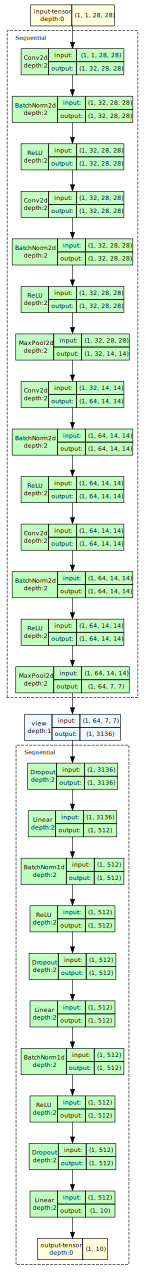

In [8]:
from torchview import draw_graph
model_graph = draw_graph(CNN(), input_size=(1,1,28,28), expand_nested=True)
model_graph.visual_graph

接下来将训练数据的分布情况可视化

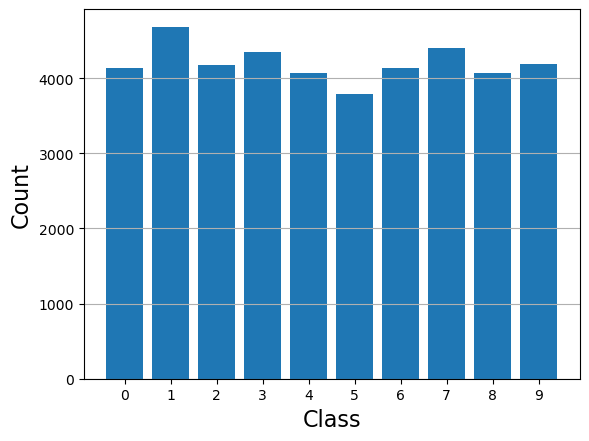

In [9]:
# 训练数据可视化
# 读取csv文件
train_df = pd.read_csv(train_csv)
#plt.rcParams['figure.figsize'] = (8, 5)
# 使用matplotlib库的bar函数绘制条形图，第一个参数为x轴的值，即类别标签；第二个参数为y轴的值，即每个类别出现的次数
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
# 设置x轴的刻度
plt.xticks(np.arange(10))
# 设置轴标签和字体大小
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
# 在y轴上添加网格线
plt.grid('on', axis='y')

接下来将一些训练集中的图像和它们对应的标签可视化

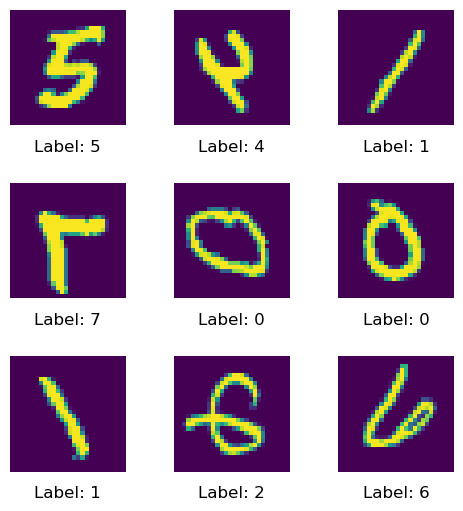

In [10]:
# 将一些训练图像及其标签可视化
# 创建子图，第一个返回值为子图对象，第二个返回值为子图中的坐标轴对象，第一个没用所以用“_”代替
_,ax = plt.subplots(3,3,figsize=(6,6))
# 设置随机种子
torch.manual_seed(81)
# 创建一个DataLoader对象，载入训练数据集，shuffle=True表示打乱数据顺序
visualize_loader = DataLoader(train_dataset, batch_size=1,shuffle=True)

# 使用enumerate函数迭代visualize_loader中的所有图像和标签。i是迭代计数器，data是一个表示图像的张量，label是一个表示标签的张量
for i, (data,label) in enumerate(visualize_loader):
    # 使用matplotlib库的imshow函数在第i//3行、第i%3列的子图中显示当前的图像。
    # data.cpu()将图像张量从GPU移动到CPU上，squeeze()函数将其大小为1的维度删除，以便正确显示图像。
    # i//3表示整除
    ax[i//3][i%3].imshow(data.cpu().squeeze())
    # 关闭当前子图的坐标轴
    ax[i//3][i%3].axis('off')
    # 在当前子图的上方设置一个标题，显示当前图像的标签。label.item()将标签张量转换为Python标量。
    ax[i//3][i%3].set_title(f"Label: {label.item()}",y=-0.3)
    # 如果已经显示了9张图像，则退出循环。
    if(i==8): break
# 调整子图之间的垂直间距
plt.subplots_adjust(hspace=0.5)
plt.show()

<br><br>
# Model Setup & Training

下面这部分代码完成了模型的建立和训练的过程，具体的执行过程在注释中给出


In [11]:
# 创建CNN
model = CNN()
# 将模型移动到指定的计算设备上，CPU或GPU
model = model.to(device)
# 定义交叉熵误差作为损失函数
criterion = nn.CrossEntropyLoss()
# 定义优化器为SGD，学习率为0.001，动量为0.9
optimizer = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)
# 定义训练过程中要执行的epoch数量
epochs = 10
# 将模型设置为训练模式，以便在训练过程中启用特定的功能（如dropout）
model.train()

# 循环，迭代训练过程的epoch数
for epoch in range(epochs):
    # 当前epoch的训练损失和准确率
    epoch_loss = 0
    epoch_accuracy = 0
    
    # 迭代训练数据集中的所有数据和标签对
    for data, label in train_loader:
        #将数据和标签移动到指定的计算设备上
        data = data.to(device)
        label = label.to(device)
        # 清除优化器中存储的之前的梯度信息，以便进行新一轮的梯度计算
        optimizer.zero_grad()
        # 使用当前模型对输入数据进行前向传播，以获得预测输出
        output = model(data)
        # 计算预测输出与实际标签之间的交叉熵损失
        loss = criterion(output, label)
        # 使用反向传播算法计算损失相对于模型参数的梯度
        loss.backward()
        # 使用优化器更新模型参数，以减小损失
        optimizer.step()
        # 将当前batch的损失加到当前epoch的总损失中，并除以训练集大小来计算平均损失。
        epoch_loss += (loss.item())/len(train_loader)
    
    # 打印当前epoch的损失
    print('Epoch : {},  train loss : {}'.format(epoch+1,epoch_loss))
    
    # 下面使用训练好的模型对验证数据集进行验证

    # 将模型设置为评估模式，以禁用特定的功能（如dropout）
    model.eval()
    # 在评估模式下，不跟踪模型中的梯度信息，以节省内存和计算资源
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        
        # 迭代验证数据集中的所有数据和标签对
        for data, label in val_loader:
            # 将数据和标签移动到指定的计算设备上
            data = data.to(device)
            label = label.to(device)

            # 使用当前模型对输入数据进行前向传播，以获得预测输出
            output = model(data)

            # 用模型对验证数据进行预测输出
            val_output = model(data)
            # 计算预测输出与实际标签之间的交叉熵损失
            val_loss = criterion(val_output,label)
            # 将当前batch的验证损失加到当前epoch的总验证损失中，并计算平均验证损失
            epoch_val_loss += val_loss/ len(val_loader)
            
        # 打印当前epoch的验证损失
        print('Epoch : {} , val_loss : {}'.format(epoch+1,epoch_val_loss))

Epoch : 1,  train loss : 0.6296529560339243
Epoch : 1 , val_loss : 0.05661933124065399
Epoch : 2,  train loss : 0.11187124974555374
Epoch : 2 , val_loss : 0.003695607651025057
Epoch : 3,  train loss : 0.06383621539426801
Epoch : 3 , val_loss : 0.0037455521523952484
Epoch : 4,  train loss : 0.04697542884059244
Epoch : 4 , val_loss : 0.0008729840046726167
Epoch : 5,  train loss : 0.03938818629270285
Epoch : 5 , val_loss : 0.0001614238426554948
Epoch : 6,  train loss : 0.031023966850960878
Epoch : 6 , val_loss : 0.0002197337889811024
Epoch : 7,  train loss : 0.027786679981888458
Epoch : 7 , val_loss : 4.180186806479469e-05
Epoch : 8,  train loss : 0.023542348591373347
Epoch : 8 , val_loss : 0.0001251931389560923
Epoch : 9,  train loss : 0.01920403886707186
Epoch : 9 , val_loss : 2.2958323825150728e-05
Epoch : 10,  train loss : 0.01714085823501663
Epoch : 10 , val_loss : 1.717725353955757e-05


# Visualizing Predictions
> 将预测结果可视化

可视化该模型的前9个预测结果。具体的操作过程是，先用 `plt.subplots()` 设定 $3\times 3$ 9个子图，再遍历测试集，取出图片进行预测，将预测结果取最大值（分类问题中将概率最大的用作结果）。当预测的图片达到9个后，跳出循环。所以在这里进行预测并可视化的是测试集中的前9个数据

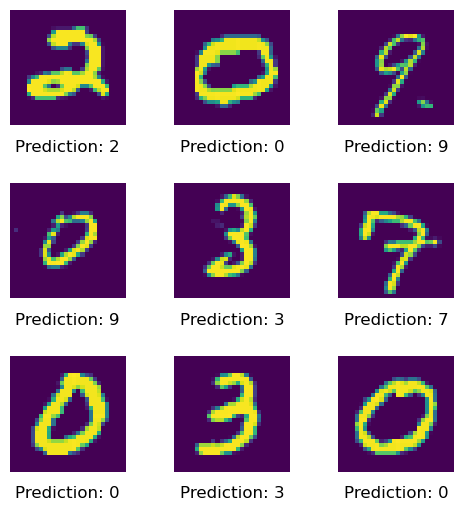

In [12]:
# 将模型设置为评估模式，会禁用dropout等操作，输出更稳定
model.eval()
# 创建一个3x3的子图
_,ax = plt.subplots(3,3,figsize=(6,6))
# 从测试数据集中逐个获取数据，i表示数据的索引，data表示数据的内容
for i, data in enumerate(test_loader):
    # 将数据加载到GPU上，以便在GPU上运行模型
    data = data.cuda()
    # 使用模型对输入数据进行预测，得到输出结果
    output = model(data)
    # 从输出结果中取出预测的类别，并将其转换为CPU格式
    pred = output.cpu().data.max(1, keepdim=True)[1]
    # 在子图中显示当前数据的图像
    ax[i//3][i%3].imshow(data.cpu().squeeze())
    # 关闭子图的坐标轴
    ax[i//3][i%3].axis('off')
    # 在子图上设置标题，标题中包含预测的类别
    ax[i//3][i%3].set_title(f"Prediction: {pred.item()}",y=-0.3)
    # 当处理完前9张测试图像后结束循环
    if(i==8): break
# 调整子图之间的垂直间距
plt.subplots_adjust(hspace=0.5)
# 显示子图
plt.show()

# Submission

最后，我们调用模型对测试集中的全部数据进行预测，并输出结果

In [13]:
# 将模型设置为评估模式
model.eval()
# 创建一个空的 LongTensor 用于存储测试数据集的预测结果
test_pred = torch.LongTensor()
# 从测试数据集中逐个获取数据，i表示数据的索引，data表示数据的内容
for i, data in enumerate(test_loader):
    # 如果有GPU可用，则将数据加载到GPU上
    if torch.cuda.is_available():
        data = data.cuda()
    # 使用模型对输入数据进行预测，得到输出结果
    output = model(data)
    # 从输出结果中取出预测的类别，并将其转换为CPU格式
    pred = output.cpu().data.max(1, keepdim=True)[1]
    # 将预测结果添加到 test_pred 中，使用 torch.cat() 函数将预测结果连接成一个张量
    test_pred = torch.cat((test_pred, pred), dim=0)
# 打印预测结果 test_pred 的形状
print(test_pred.shape)
# 从指定路径读取示例提交文件，并将其存储在 submission_df 变量中
submission_df = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
# 将预测结果 test_pred 转换为numpy数组，使用 squeeze() 函数去除维度为1的维度，将其赋值给 submission_df 中的 Label 列
submission_df['Label'] = test_pred.numpy().squeeze()
# 将 submission_df 存储为CSV文件，文件名为 submission.csv，并将索引列设置为 False，以便不将索引列写入CSV文件。
submission_df.to_csv('submission.csv', index=False)

torch.Size([28000, 1])
